# Robyn Budget Allocator Demo

This notebook demonstrates how to use the Python implementation of Robyn's budget allocator.
It shows how to:
1. Load and prepare data
2. Configure the allocator
3. Run optimization scenarios
4. Analyze and visualize results

## Step 1: Load Exported R Data

In [1]:
## Step 1: Setup and Import
import sys
import os
import pandas as pd
import numpy as np
from typing import Dict, Any, Union, List
import matplotlib.pyplot as plt

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

# Import necessary Robyn classes
from robyn.data.entities.mmmdata import MMMData
from robyn.modeling.entities.modeloutputs import ModelOutputs
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.modeling.pareto.pareto_optimizer import ParetoResult
from utils.data_mapper import (
    load_data_from_json,
    import_input_collect,
    import_output_collect,
    import_output_models,
)

2024-11-26 09:26:23,678 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data from JSON exported from R
# raw_input_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/dh_Pareto_InputCollect.json"
# )
# raw_output_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/dh_Allocator_OutputCollect.json"
# )

raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/yj_InputCollect.json"
)
raw_output_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/yj_OutputCollect.json"
)

# raw_input_collect = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_InputCollect.json"
# )
# raw_output_collect = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputCollect.json"
# )
# raw_output_models = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputModels.json"
# )

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_collect = import_output_collect(raw_output_collect)
# python_model_outputs = import_output_models(raw_output_models)

# Extract individual components
mmm_data = r_input_collect["mmm_data"]
featurized_mmm_data = r_input_collect["featurized_mmm_data"]
holidays_data = r_input_collect["holidays_data"]
hyperparameters = r_input_collect["hyperparameters"]

# Print data summary
print(f"Data loaded successfully:")
print(
    f"- Data timeframe: {mmm_data.data[mmm_data.mmmdata_spec.date_var].min()} to {mmm_data.data[mmm_data.mmmdata_spec.date_var].max()}"
)
print(
    f"- Number of paid media channels: {len(mmm_data.mmmdata_spec.paid_media_spends)}"
)
print(f"- Channels: {mmm_data.mmmdata_spec.paid_media_spends}")

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Raw hyperparameters data: {'facebook_S_alphas': [0.5, 3], 'facebook_S_gammas': [0.3, 1], 'facebook_S_thetas': [0, 0.3], 'print_S_alphas': [0.5, 3], 'print_S_gammas': [0.3, 1], 'print_S_thetas': [0.1, 0.4], 'tv_S_alphas': [0.5, 3], 'tv_S_gammas': [0.3, 1], 'tv_S_thetas': [0.3, 0.8], 'search_S_alphas': [0.5, 3], 'search_S_gammas': [0.3, 1], 'search_S_thetas': [0, 0.3], 'ooh_S_alphas': [0.5, 3], 'ooh_S_gammas': [0.3, 1], 'ooh_S_thetas': [0.1, 0.4], 'newsletter_alphas': [0.5, 3], 'newsletter_gammas': [0.3, 1], 'newsletter_thetas': [0.1, 0.4], 'train_size': [0.5, 0.8]}
Data loaded successfully:
- Data timeframe: 2015-11-23 00:00:00 to 2019-11-11 00:00:00
- Number of paid media channels: 5
- Channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


## Step 2: Set up Budget Allocator

Initialize the budget allocator with the selected model and data.

In [3]:
# select_model = r_output_collect["pareto_result"].pareto_solutions[
#     0
# ]  # Taking first solution as example
# print(f"Selected model: {select_model}")

In [4]:
for i in raw_output_collect["clusters"]["models"]:
    print(i["solID"])

3_216_3
3_206_5
4_182_3


In [5]:
# Override
select_model = "3_216_3"

## Step 3: Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [6]:
print("Hyperparameters raw output:", hyperparameters)

Hyperparameters raw output: Hyperparameters(
  facebook_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  print_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  tv_S=Hyperparameter(
  thetas=[0.3, 0.8],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  search_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  ooh_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  newsletter=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
)


In [7]:
# Assuming `hyperparameters` is an instance of the `Hyperparameters` class

# Iterate over each channel and its hyperparameters
for channel, params in hyperparameters.hyperparameters.items():
    print(f"Channel: {channel}")
    print(f"  Thetas: {params.thetas}")
    print(f"  Shapes: {params.shapes}")
    print(f"  Scales: {params.scales}")
    print(f"  Alphas: {params.alphas}")
    print(f"  Gammas: {params.gammas}")
    print(f"  Penalty: {params.penalty}")
    print()

# Print other attributes of the Hyperparameters class
print(f"Adstock: {hyperparameters.adstock}")
print(f"Lambda: {hyperparameters.lambda_}")
print(f"Train Size: {hyperparameters.train_size}")

Channel: facebook_S
  Thetas: [0, 0.3]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: print_S
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: tv_S
  Thetas: [0.3, 0.8]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: search_S
  Thetas: [0, 0.3]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: ooh_S
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: newsletter
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Adstock: geometric
Lambda: 0.0
Train Size: [0.5, 0.8]


In [8]:
print(hyperparameters.adstock.value)

geometric


In [9]:
from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.entities.allocation_result import (
    AllocationResult,
    OptimOutData,
    MainPoints,
)
from robyn.allocator.entities.optimization_result import OptimizationResult
from robyn.allocator.entities.constraints import Constraints
from robyn.allocator.optimizer import BudgetAllocator
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    ALGO_SLSQP_AUGLAG,
    CONSTRAINT_MODE_EQ,
    DEFAULT_CONSTRAINT_MULTIPLIER,
    DATE_RANGE_ALL,
)


# Create allocator parameters matching R Example 1
allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # When None, uses total spend in date_range
    target_value=None,
    date_range="all",
    channel_constr_low=[0.7],  # Single value for all channels
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Different values per channel
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)
# 0.7 is the lower bound
# 1.2 is the upper bound for the first channel, and so on
# $70 - $150
# let's say $100, budget allocator is about increasing decreasing media budget, advertiser wants to know how much to spend on each channel
# you cannot be infinitely increasing budget, so you have to set constraints
# 0.7 - 1.2 means you can increase by 20% or decrease by 30%
# Boundedx3 = 3x increase or decrease, so 90% lower bound, 150% upper bound.

print("\nInitial constraints:")
for channel, low, up in zip(
    mmm_data.mmmdata_spec.paid_media_spends,
    [0.7] * len(mmm_data.mmmdata_spec.paid_media_spends),  # Expand single value
    [1.2, 1.5, 1.5, 1.5, 1.5],  # Per channel values
):
    print(f"{channel}: {low:.1f}x - {up:.1f}x")

# Initialize budget allocator
max_response_allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=r_output_collect["pareto_result"],
    select_model=select_model,
    params=allocator_params,
)

## Step 3: Run Optimization
max_response_result = max_response_allocator.optimize()

2024-11-26 09:26:28,556 - robyn.allocator.optimizer - WARNING - The following media channels have zero coefficients and will be excluded: facebook_S



Initial constraints:
tv_S: 0.7x - 1.2x
ooh_S: 0.7x - 1.5x
print_S: 0.7x - 1.5x
facebook_S: 0.7x - 1.5x
search_S: 0.7x - 1.5x
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -59212.98793541127
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -58383.32096792152
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -60295.56386864104
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -60261.117728179626
            Iterations: 26
            Function evaluations: 128
            Gradient evaluations: 22
Inequality constraints incompatible    

/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


In [10]:
## Step 4: Analyze Results
print("\nOptimization Results Summary:")
print("-" * 50)
print(f"Model ID: {select_model}")
print(f"Scenario: {max_response_result.scenario}")
print(f"Use case: {max_response_result.usecase}")

results_df = pd.DataFrame(
    {
        "Channel": max_response_result.dt_optimOut.channels,
        "Initial Spend": max_response_result.dt_optimOut.init_spend_unit,
        "Optimized Spend": max_response_result.dt_optimOut.optm_spend_unit,
        "Spend Change %": (
            max_response_result.dt_optimOut.optm_spend_unit
            / max_response_result.dt_optimOut.init_spend_unit
            - 1
        )
        * 100,
        "Initial Response": max_response_result.dt_optimOut.init_response_unit,
        "Optimized Response": max_response_result.dt_optimOut.optm_response_unit,
        "Response Lift %": (
            max_response_result.dt_optimOut.optm_response_unit
            / max_response_result.dt_optimOut.init_response_unit
            - 1
        )
        * 100,
    }
)

print("\nDetailed Results:")
print(results_df.round(2))

# Print additional diagnostics
print("\nOptimization Parameters:")
print(f"Total budget: {max_response_allocator.constraints.budget_constraint:,.2f}")
print("Bound multiplier:", max_response_allocator.params.channel_constr_multiplier)
print("\nConstraint Violations:")
violations = np.sum(
    np.abs(
        max_response_result.dt_optimOut.optm_spend_unit
        - max_response_allocator.init_spend_unit
    )
)
print(f"Total allocation adjustment: {violations:,.2f}")


Optimization Results Summary:
--------------------------------------------------
Model ID: 3_216_3
Scenario: max_response
Use case: all_historical_vec + historical_budget

Detailed Results:
      Channel  Initial Spend  Optimized Spend  Spend Change %  \
0        tv_S       16282.26         11397.58          -30.00   
1       ooh_S       52818.55         56310.65            6.61   
2     print_S        3856.63          2699.64          -30.00   
3  facebook_S        2141.53          2141.53            0.00   
4    search_S        5099.15          7648.72           50.00   

   Initial Response  Optimized Response  Response Lift %  
0            506.10              173.93           -65.63  
1          48934.06            50149.29             2.48  
2            626.02              246.21           -60.67  
3              0.00                0.00              NaN  
4           4125.20             9726.14           135.77  

Optimization Parameters:
Total budget: 80,198.11
Bound multipli

/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_88643/54381451.py:22: RuntimeWarning: invalid value encountered in divide
  max_response_result.dt_optimOut.optm_response_unit


In [11]:
print(max_response_result.dt_optimOut)
print(max_response_result.mainPoints)

OptimOutData(channels=array(['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S'], dtype='<U10'), init_spend_unit=array([16282.25794744, 52818.550425  ,  3856.63447244,  2141.52578141,
        5099.14529936]), init_response_unit=array([  506.09912477, 48934.05550682,   626.01852897,     0.        ,
        4125.19885988]), optm_spend_unit=array([11397.58056321, 56310.64550138,  2699.64413071,  2141.52578141,
        7648.71794894]), optm_response_unit=array([  173.92548291, 50149.28716695,   246.21395421,     0.        ,
        9726.13726458]), optm_spend_unit_unbound=array([11397.58056321, 53607.30038223,  5404.10983122,  2141.52578141,
        7647.59736756]), optm_response_unit_unbound=array([  173.92548291, 49214.16799839,  1501.47766186,     0.        ,
        9723.55716435]), date_min='2016-01-04 00:00:00', date_max='2018-12-24 00:00:00', metric='ROAS', periods='156 weeks')
MainPoints(response_points=array([[  506.09912477, 48934.05550682,   626.01852897,     0.        ,
     

2024-11-26 09:26:28,961 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-26 09:26:28,962 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-26 09:26:28,962 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2024-11-26 09:26:28,962 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 3_216_3
2024-11-26 09:26:28,963 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot
2024-11-26 09:26:29,010 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot
2024-11-26 09:26:29,139 - robyn.visualization.allocator_visualizer - INFO - Creating response curves plot


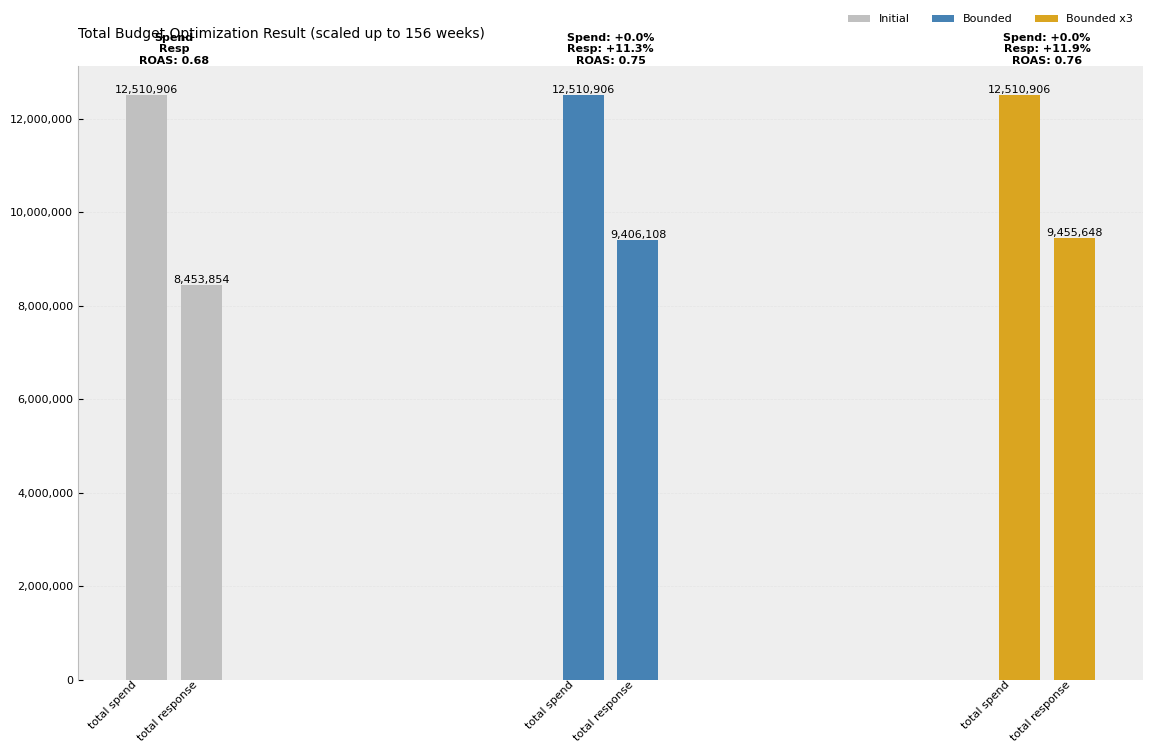

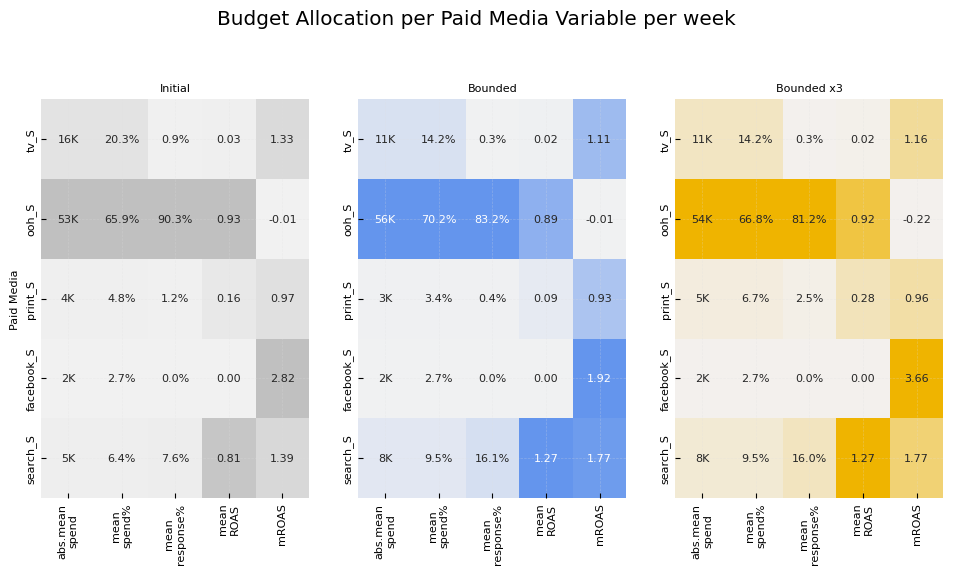

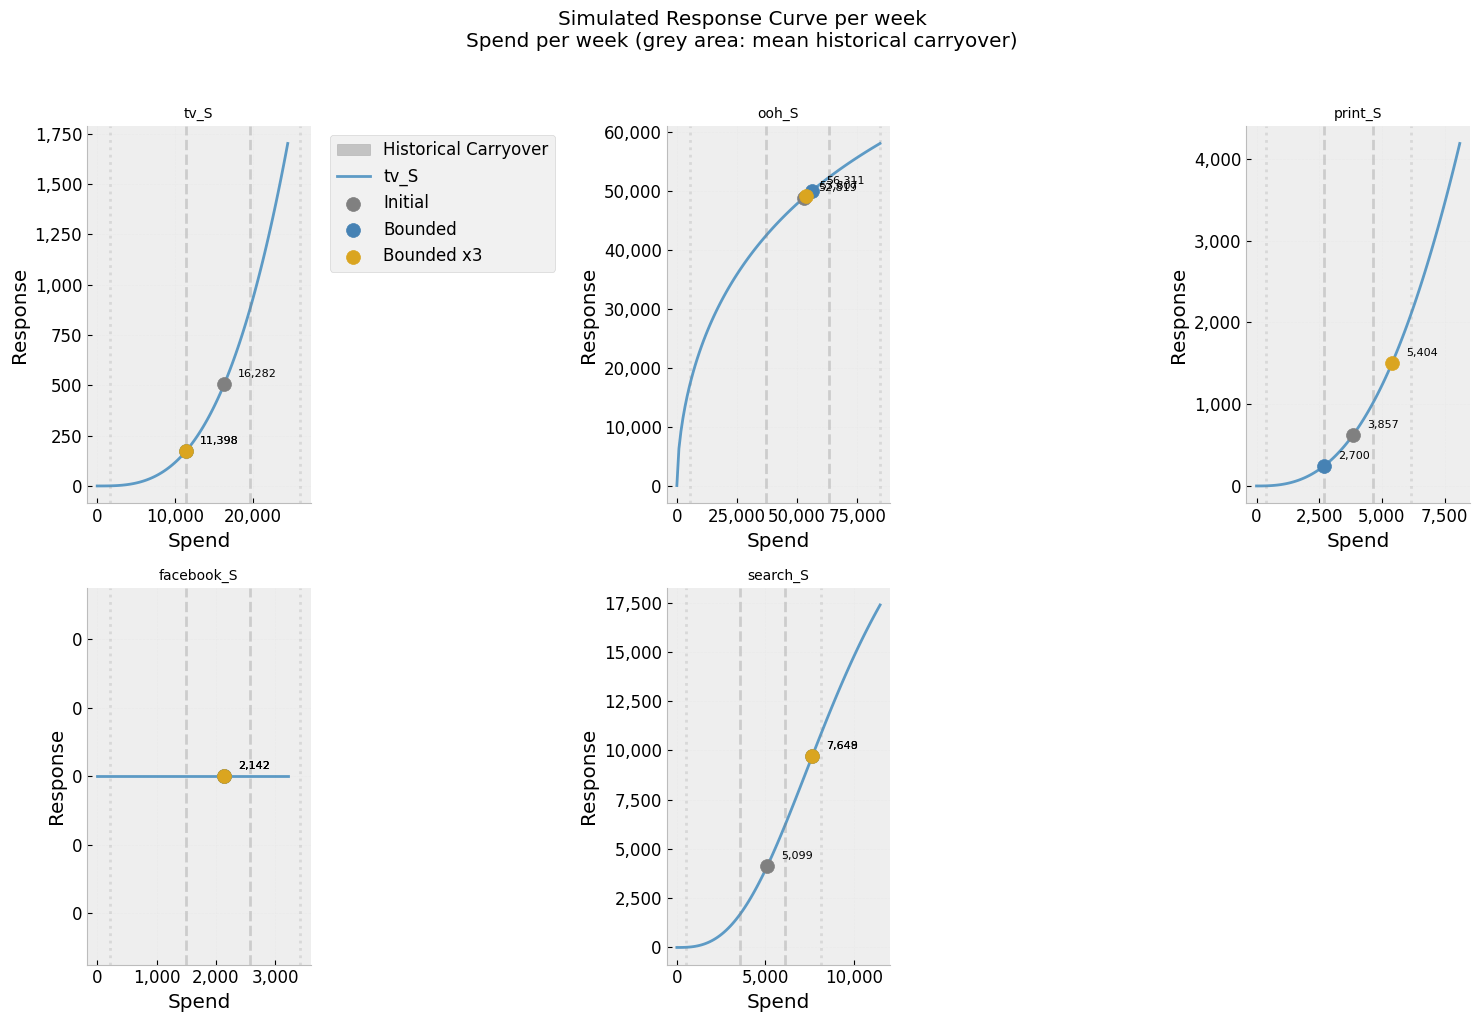

In [12]:
from robyn.visualization.allocator_visualizer import (
    AllocatorPlotter,
)
%load_ext autoreload
%autoreload 2
# Initialize plotter with just the essential data
plotter = AllocatorPlotter(
    allocation_result=max_response_result,
    budget_allocator=max_response_allocator
)

# Generate all plots
plots = plotter.plot_all(display_plots=False, export_location=None)

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [13]:
from robyn.allocator.constants import (
    SCENARIO_TARGET_EFFICIENCY,  # Import this instead of SCENARIO_MAX_RESPONSE
    ALGO_SLSQP_AUGLAG,
    CONSTRAINT_MODE_EQ,
    DEFAULT_CONSTRAINT_MULTIPLIER,
    DATE_RANGE_ALL,
)

# Create allocator parameters matching R Example 3 for target efficiency
allocator_params = AllocatorParams(
    scenario=SCENARIO_TARGET_EFFICIENCY,  # Change scenario
    total_budget=None,  # When None, it will use all available dates
    # target_value is optional - when None:
    # - For revenue (ROAS): defaults to 0.8x of initial ROAS
    # - For conversion (CPA): defaults to 1.2x of initial CPA
    target_value=None,
    date_range="all",
    # Use default constraints
    channel_constr_low=[
        0.1
    ],  # Lower constraint for target_efficiency typically starts at 0.1
    channel_constr_up=[
        10
    ],  # Upper constraint for target_efficiency typically goes up to 10
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)

# Initialize and run allocator same as before
target_efficiency_allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=r_output_collect["pareto_result"],
    select_model=select_model,
    params=allocator_params,  # or allocator_params_custom
)

# Run optimization
target_efficiency_result = target_efficiency_allocator.optimize()

2024-11-26 09:26:29,888 - robyn.allocator.optimizer - WARNING - The following media channels have zero coefficients and will be excluded: facebook_S
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization terminated successfully    (Exit mode 0)
            Current function value: -437300.54470975394
            Iterations: 48
            Function evaluations: 235
            Gradient evaluations: 47
Optimization terminated successfully    (Exit mode 0)
            Current function value: -158843.68278202016
            Iterations: 107
            Function evaluations: 574
            Gradient evaluations: 104
Optimization terminated successfully    (Exit mode 0)
            Current function value: -437300.54470975394
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -437300.54470975394
            Iterations: 40
            Function evaluations: 195
            Gradient evaluations: 39
Optimization terminated successfully    (Exit mode 0)
            Current function value: -437300.54470975394
            Iterations: 35
            Funct

In [14]:
## Step 4: Analyze Results
print("\nOptimization Results Summary:")
print("-" * 50)
print(f"Model ID: {select_model}")
print(f"Scenario: {target_efficiency_result.scenario}")
print(f"Use case: {target_efficiency_result.usecase}")

results_df = pd.DataFrame(
    {
        "Channel": target_efficiency_result.dt_optimOut.channels,
        "Initial Spend": target_efficiency_result.dt_optimOut.init_spend_unit,
        "Optimized Spend": target_efficiency_result.dt_optimOut.optm_spend_unit,
        "Spend Change %": (
            target_efficiency_result.dt_optimOut.optm_spend_unit
            / target_efficiency_result.dt_optimOut.init_spend_unit
            - 1
        )
        * 100,
        "Initial Response": target_efficiency_result.dt_optimOut.init_response_unit,
        "Optimized Response": target_efficiency_result.dt_optimOut.optm_response_unit,
        "Response Lift %": (
            target_efficiency_result.dt_optimOut.optm_response_unit
            / target_efficiency_result.dt_optimOut.init_response_unit
            - 1
        )
        * 100,
    }
)

print("\nDetailed Results:")
print(results_df.round(2))

# Print additional diagnostics
print("\nOptimization Parameters:")
if target_efficiency_allocator.constraints.budget_constraint is not None:
    print(
        f"Total budget: {target_efficiency_allocator.constraints.budget_constraint:,.2f}"
    )
else:
    print("Total budget: Unconstrained (Target Efficiency Mode)")
print("Bound multiplier:", target_efficiency_allocator.params.channel_constr_multiplier)

print("\nConstraint Violations:")
violations = np.sum(
    np.abs(
        target_efficiency_result.dt_optimOut.optm_spend_unit
        - target_efficiency_allocator.init_spend_unit
    )
)
print(f"Total allocation adjustment: {violations:,.2f}")


Optimization Results Summary:
--------------------------------------------------
Model ID: 3_216_3
Scenario: target_efficiency
Use case: all_historical_vec + historical_budget

Detailed Results:
      Channel  Initial Spend  Optimized Spend  Spend Change %  \
0        tv_S       16282.26        162822.58           900.0   
1       ooh_S       52818.55        528185.50           900.0   
2     print_S        3856.63         38566.34           900.0   
3  facebook_S        2141.53          2141.53             0.0   
4    search_S        5099.15         50991.45           900.0   

   Initial Response  Optimized Response  Response Lift %  
0            506.10           260329.94         51338.53  
1          48934.06            95421.60            95.00  
2            626.02            53835.49          8499.66  
3              0.00                0.00              NaN  
4           4125.20            27713.52           571.81  

Optimization Parameters:
Total budget: Unconstrained (Targ

/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_88643/1524984118.py:22: RuntimeWarning: invalid value encountered in divide
  target_efficiency_result.dt_optimOut.optm_response_unit


In [15]:
print(target_efficiency_result.dt_optimOut)
print(target_efficiency_result.mainPoints)

OptimOutData(channels=array(['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S'], dtype='<U10'), init_spend_unit=array([16282.25794744, 52818.550425  ,  3856.63447244,  2141.52578141,
        5099.14529936]), init_response_unit=array([  506.09912477, 48934.05550682,   626.01852897,     0.        ,
        4125.19885988]), optm_spend_unit=array([162822.57947436, 528185.50425   ,  38566.34472436,   2141.52578141,
        50991.45299359]), optm_response_unit=array([260329.93908466,  95421.5957896 ,  53835.48824136,      0.        ,
        27713.52159413]), optm_spend_unit_unbound=array([455903.22252821, 702308.97319687, 106915.97372978,   2141.52578141,
        44392.7001775 ]), optm_response_unit_unbound=array([514840.82914214, 100563.85658775,  66058.06899463,      0.        ,
        27589.18034769]), date_min='2016-01-04 00:00:00', date_max='2018-12-24 00:00:00', metric='ROAS', periods='156 weeks')
MainPoints(response_points=array([[5.06099125e+02, 4.89340555e+04, 6.26018529e+02, 0

2024-11-26 09:26:30,432 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-26 09:26:30,432 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-26 09:26:30,433 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2024-11-26 09:26:30,433 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 3_216_3
2024-11-26 09:26:30,433 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot
2024-11-26 09:26:30,459 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot
2024-11-26 09:26:30,588 - robyn.visualization.allocator_visualizer - INFO - Creating response curves plot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


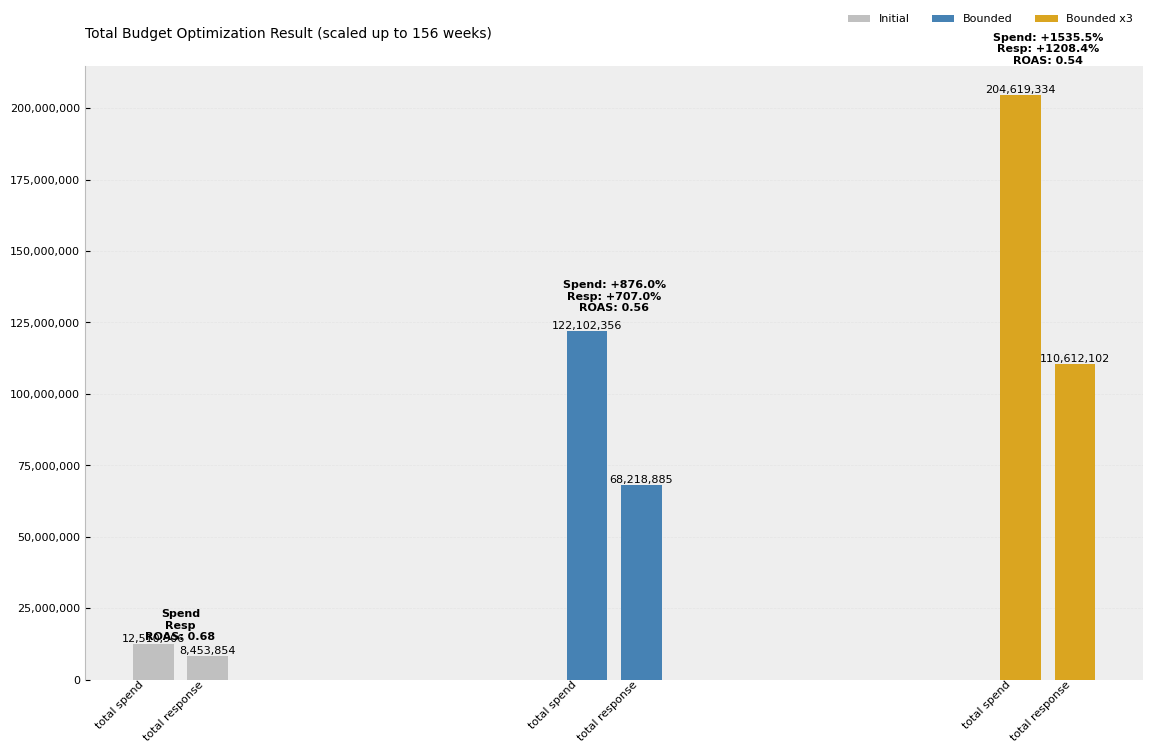

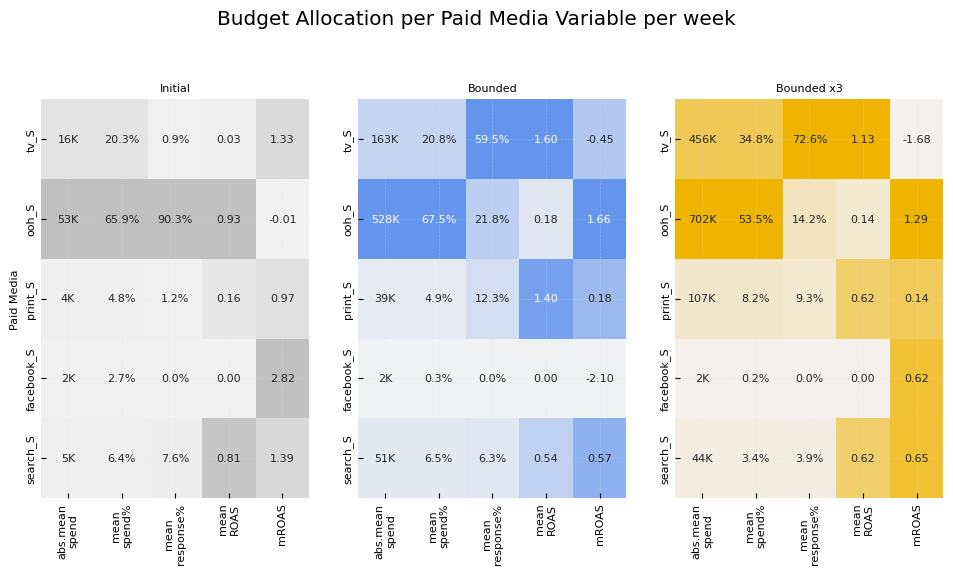

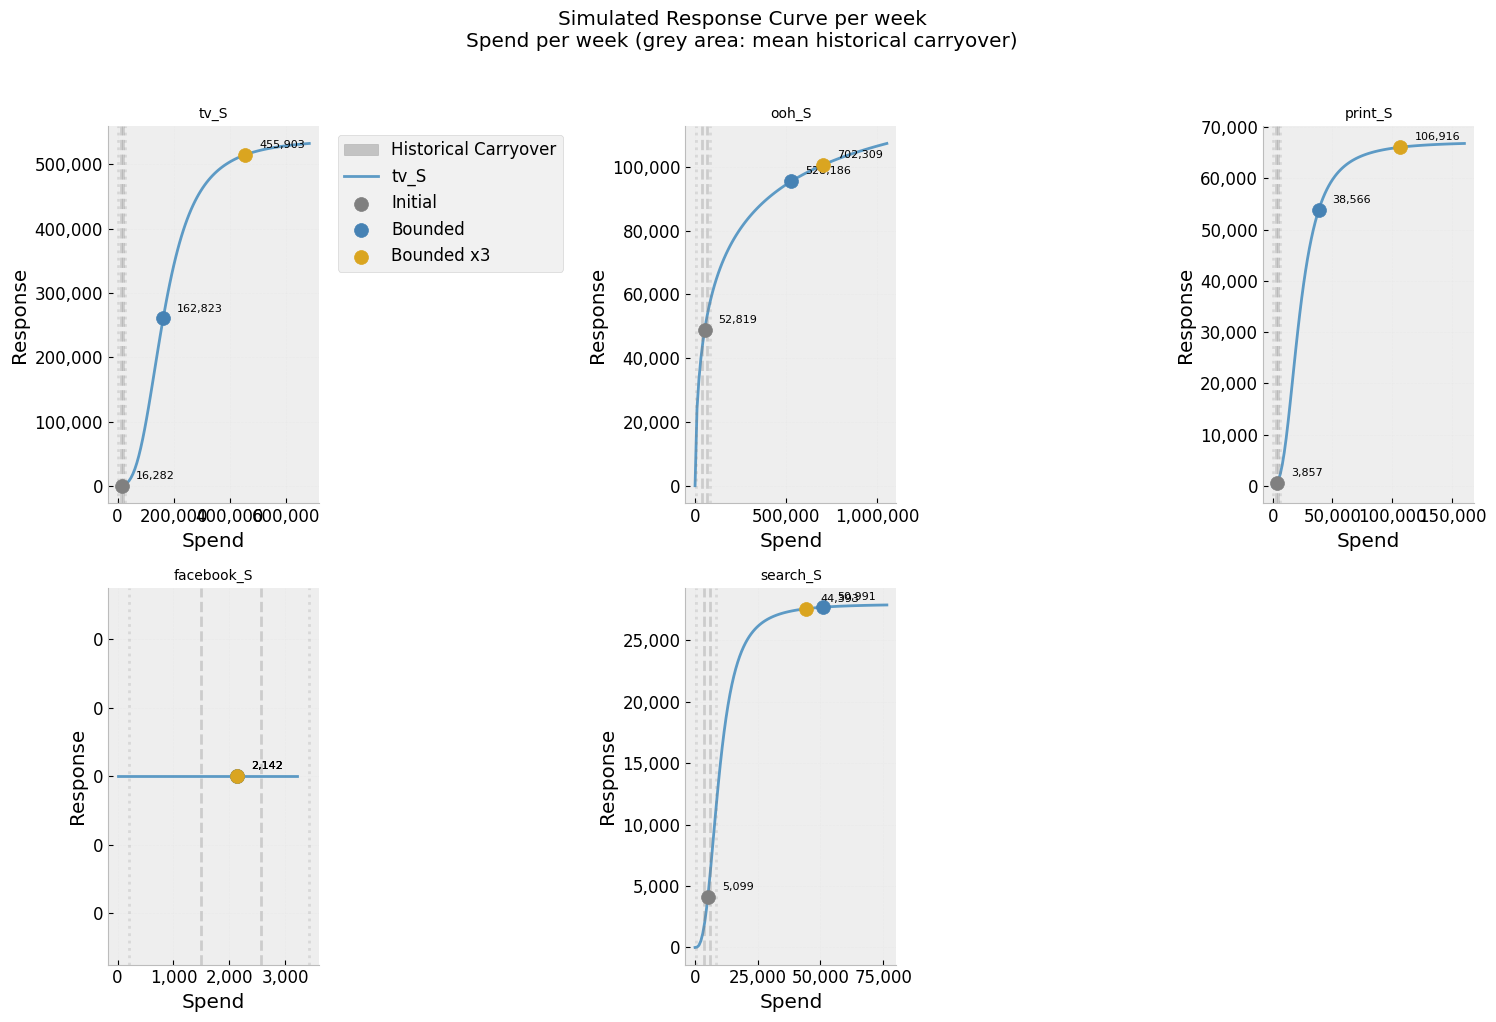

In [16]:
from robyn.visualization.allocator_visualizer import (
    AllocatorPlotter,
)
%load_ext autoreload
%autoreload 2
# Initialize plotter with just the essential data
plotter = AllocatorPlotter(
    allocation_result=target_efficiency_result,
    budget_allocator=target_efficiency_allocator
)

# Generate all plots
plots = plotter.plot_all(display_plots=False, export_location=None)